In [1]:
import logging
import numpy as np
import torch
from PIL import Image
from functools import lru_cache
from functools import partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm
import imageio
import matplotlib.image as mpimg
import tifffile
from torch import nn
import torchvision
from torchvision.transforms import v2
from torchvision import transforms
import torchvision.transforms.functional as TF
import random

In [2]:
def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext == ".tif":
        tif_data = tifffile.imread(filename)[:,:,0]
        return tif_data
    elif ext == ".png":
        return np.array(Image.open(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        return Image.open(filename)

In [3]:
def generate_gradient(shape: tuple[int, int]) -> np.ndarray:              
    
    '''
    Inputs in format (H, W)
    Outputs a gradient from 0 to 1 in both x and y directions
    Channel 0 gradient on W and Channel 1 gradient on H
    '''
    
    xx, yy = np.meshgrid(np.linspace(0, 1, shape[1]), np.linspace(0, 1, shape[0]))
    gradient = np.stack([xx, yy], axis=-1)
    return gradient

In [4]:
def get_input_data(filename) -> np.ndarray: 
    
    '''
    Load image from filename (tiff, png, npy, pt) and generates the gradient on the size of the image
    Concatenate them and return the result in np.array
    (H, W, C), C = 2
    '''
    
    data = load_image(filename)
    gradient = generate_gradient(data.shape)[:,:,1]
    return np.concatenate([np.expand_dims(data, axis=2), np.expand_dims(gradient, axis=2)], axis=2)

In [5]:
def unique_mask_values(idx, mask_dir, mask_suffix):
    
    
    '''
    Return the unique values of a mask
    '''

    try:
        mask_file = list(mask_dir.glob(idx + mask_suffix + '.*'))[0]        # Use the first sample 
    
    except IndexError:
        raise FileNotFoundError(f'No mask file found for image {idx}')
    
    mask = np.asarray(load_image(mask_file))
    if mask.ndim == 2:
        return np.unique(mask)
    elif mask.ndim == 3:
        mask = mask.reshape(-1, mask.shape[-1])
        return np.unique(mask, axis=0)
    else:
        raise ValueError(f'Loaded masks should have 2 or 3 dimensions, found {mask.ndim}')

In [6]:
data_filename = "data/images/train/il_0.tif"
mask_filename = "data/annotations/train/il_0.png"

In [7]:
mask = load_image(mask_filename)
mask[:,:].shape

(255, 701)

In [8]:
teste = get_input_data(data_filename)
teste[:,:,0], teste[:,:,1], type(teste), teste[:,:,0].shape

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00829577,  0.00636416,  0.00370673, ..., -0.04055443,
         -0.0451528 , -0.04827393],
        [ 0.0501296 ,  0.04737168,  0.02804823, ..., -0.23444323,
         -0.25487701, -0.26996967],
        ...,
        [ 0.24166922,  0.12021541,  0.13181945, ...,  0.06050743,
          0.06330186,  0.05875252],
        [ 0.24751962,  0.13917661,  0.14523736, ...,  0.0554414 ,
          0.06327252,  0.06000922],
        [ 0.24751962,  0.13917661,  0.14523736, ...,  0.0554414 ,
          0.06327252,  0.06000922]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00393701, 0.00393701, 0.00393701, ..., 0.00393701, 0.00393701,
         0.00393701],
        [0.00787402, 0.00787402, 0.00787402, ..., 0.00787402, 0.00787402,
         0.00787402],
        ...,
        [0.99212598, 0.99212598, 0.99212598, ..., 0.99212598, 0.99212598

In [9]:
teste[:,:,1].max(), teste[:,:,1].min()

(1.0, 0.0)

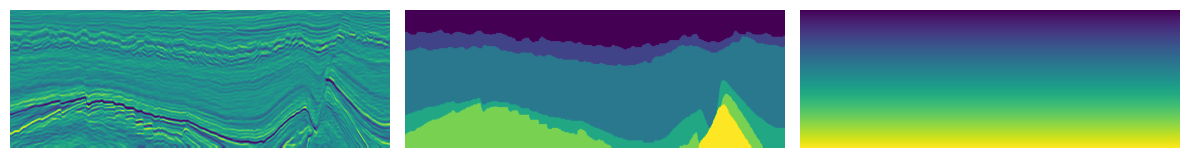

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(teste[:,:,0])
axs[1].imshow(mask)
axs[2].imshow(teste[:,:,1])

# Remove the axis labels
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [14]:
from datasets import *

In [15]:
data_dir = "data/images/train"
mask_dir = "data/annotations/train"

dataset = BasicDataset(data_dir=data_dir, mask_dir=mask_dir, transform=True) 

100%|██████████| 992/992 [00:10<00:00, 91.21it/s] 


In [21]:
idx = random.randint(0, len(dataset))

data_teste, mask_teste = dataset[idx]['image'], dataset[idx]['mask']

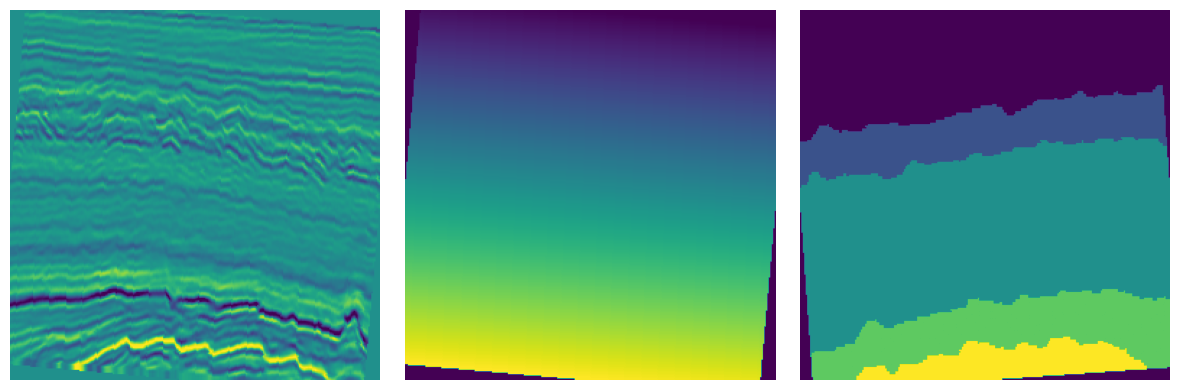

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(data_teste[0,:,:])
axs[1].imshow(data_teste[1,:,:])
axs[2].imshow(mask_teste[0])

# Remove the axis labels
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()